# Exercises

## Exercise 1
---

You can find below the code that was used to generate the activity of place cells on a linear track.
Use the code and the decoding procedure you lerned about in the lesson to explore how different features of the data impact our ability to decode position.
In particular:

A - Try to use different fractions of our data samples. How does the median error change when the the number of available sample gets larger? You do not need to re-generate any data, just randomly sub-sample the data to different fractions.

B - How many place cells do we need to reliably decode position? Try to re-do the decoding using only 10 cell, then 20, and so on. How does the median error change? Does it reach an asymptote? (Also in this case, you do not need to re-generate the data, you can just select a random subset of cells each time)

C - Generate new data using the code below, changing the firing rate noise (changing the value of the variable `noise firing_rate`). How does this noise impact the decoding? 

In [32]:
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import pickle
from scipy.stats import poisson

sys.path.append(os.path.abspath("code"))
from utils import download_data


%matplotlib inline 
plt.rcParams['figure.figsize'] = [10, 5]
from ipywidgets import interact
import ipywidgets as widgets

In [33]:
track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution


bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

In [34]:
# GENERATE TRAJECTORY

n_runs = 10
use_stops = False
av_running_speed = 10 # the average running speed (in cm/s)
fps = 10 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])


for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    if use_stops:
        x = np.concatenate((x, stop1, run1, stop2, run2))
    else:
         x = np.concatenate((x, run1, run2))
t = np.arange(len(x))/fps

In [35]:
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1 # the baseline noise firing rate
spikes = []

for i in range(n_cells):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

In [49]:
spike_positions = [np.interp(s, t, x) for s in spikes]
space_bins = np.arange(0., track_length, 5.) # binning in bins of 5 cms

spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
spikes_hist = np.asarray(spikes_hist)

occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy 

spikes_count= [np.histogram(s,t)[0] for s in spikes]
spikes_count = np.asarray(spikes_count).T 

In [42]:
true_x_original = x[:-1] # get rid of last timepoint to have same length as binned spikes
decoding_times = t[:-1]
x_decoded_original = np.zeros_like(true_x_original)

for t_bin in tqdm(range(len(decoding_times))): # disable False/True: to show/not-show the progress bars
    if sum(spikes_count[t_bin,:]) > 0: # Check if the time window contains spikes
        posterior = np.empty(firing_rate_maps.shape[-1])
        for i in range(len(posterior)):
            # Note that we work with log so that we can sum probabilities instead of multiplying them 
            posterior[i] = np.sum(poisson.logpmf(spikes_count[t_bin,:], firing_rate_maps[:,i]/fps) + 1e-15)
        x_decoded_original[t_bin] = space_bins[np.argmax(posterior)]
    else:
        x_decoded_original[t_bin] = np.nan 

# compute decoding error only for sampled indices
mse_original = np.sqrt((true_x_original - x_decoded_original)**2)
median_error_original = np.nanmedian(mse_original)

print(median_error_original)

100%|██████████| 4891/4891 [00:03<00:00, 1295.72it/s]

3.6981132075471734


Until here, nothing is new. We now do A)

In [47]:
# Prepare data
true_positions = x[:-1]
time_bins = t[:-1]

# Sampling fractions to test
sample_size = [0.01, 0.1, 0.15, 0.3, 0.5, 0.75, 0.8, 0.9]
med_errors_final = []

num_realizations = 5  # Number of times to repeat the experiment

# Loop over each sampling fraction
for i in sample_size:
    realization_errors = []
    
    for realization_idx in range(num_realizations):
        # Randomly select time bin indices based on the current fraction
        num_sampled_bins = int(len(time_bins) * i)
        sampled_time_indices = np.sort(np.random.choice(len(time_bins), num_sampled_bins, replace=False))
        
        decoded_positions = np.zeros(np.shape(true_positions))
        
        # Decode position for each sampled time bin
        for time_idx in tqdm(sampled_time_indices, disable=True):
            if np.sum(spikes_count[time_idx, :]) > 0:  # Only decode if there are spikes
                posterior_log_probs = np.empty(firing_rate_maps.shape[-1])
                
                # Compute log-posterior for each spatial bin
                for bin_idx in range(len(posterior_log_probs)):
                    firing_rate = firing_rate_maps[:, bin_idx] / fps
                    log_likelihood = poisson.logpmf(spikes_count[time_idx, :], firing_rate) + 1e-15
                    posterior_log_probs[bin_idx] = np.sum(log_likelihood)
                
                # Decode position as the bin with maximum posterior probability
                decoded_positions[time_idx] = space_bins[np.argmax(posterior_log_probs)]
            else:
                decoded_positions[time_idx] = np.nan
        
        # Compute decoding error for sampled indices
        decoding_errors = np.sqrt((true_positions[sampled_time_indices] - decoded_positions[sampled_time_indices]) ** 2)
        median_error = np.nanmedian(decoding_errors)
        
        realization_errors.append(median_error)
 
    mean_median_error = np.mean(realization_errors)
    med_errors_final.append(mean_median_error)


In [51]:
for i in range(len(sample_size)):
    frac = sample_size[i]
    median_error = med_errors_final[i]
    print(f"Sampled fraction: {frac*100:.0f}%"+f", Median error: {median_error:.2f} cm")

Sampled fraction: 1%, Median error: 3.78 cm
Sampled fraction: 10%, Median error: 3.62 cm
Sampled fraction: 15%, Median error: 3.81 cm
Sampled fraction: 30%, Median error: 3.68 cm
Sampled fraction: 50%, Median error: 3.73 cm
Sampled fraction: 75%, Median error: 3.71 cm
Sampled fraction: 80%, Median error: 3.70 cm
Sampled fraction: 90%, Median error: 3.69 cm


Now to B)
    

In [60]:
def n_c(n):
    track_length = 200. # the length of our linear track (eg in centimeter)
    average_firing_rate = 5 # the peak firing rate, averaged across the population 
    n_cells = n # how many cells we are recording
    pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
    pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
    pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution


    bins = np.arange(0., 200.)
    true_firing_rate_maps = np.zeros((n_cells, len(bins)))
    for i in range(n_cells):
        true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

    n_runs = 10
    use_stops = False
    av_running_speed = 10 # the average running speed (in cm/s)
    fps = 10 # the number of "video frames" per second 
    running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
    running_speed_b = np.random.chisquare(10, size=n_runs) 

    stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
    stopping_time_b = np.random.chisquare(15, size=n_runs)

    x = np.array([])


    for i in range(n_runs):
        stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
        run_length = len(bins) * fps / running_speed_a[i]
        run1 = np.linspace(0., float(len(bins)-1), int(run_length))
        stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
        run_length = len(bins) * fps / running_speed_b[i]
        run2 = np.linspace(len(bins)-1., 0., int(run_length))
        if use_stops:
            x = np.concatenate((x, stop1, run1, stop2, run2))
        else:
            x = np.concatenate((x, run1, run2))
    t = np.arange(len(x))/fps

    sampling_rate = 10000.
    t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
    x_sampling = np.floor(np.interp(t_sampling, t, x))
    noise_firing_rate = 0.1 # the baseline noise firing rate
    spikes = []

    for i in range(n_cells):
        inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
        spikes_loc = np.random.poisson(inst_rate/sampling_rate)
        sp = np.argwhere(spikes_loc)
        t_sp = t_sampling[sp]
        spikes.append(t_sp)

    spike_positions = [np.interp(s, t, x) for s in spikes]
    space_bins = np.arange(0., track_length, 5.) # binning in bins of 5 cms

    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.asarray(spikes_hist)

    occupancy = np.histogram(x, space_bins)[0] /  fps

    firing_rate_maps = spikes_hist / occupancy 

    spikes_count= [np.histogram(s,t)[0] for s in spikes]
    spikes_count = np.asarray(spikes_count).T 

    true_x_original = x[:-1] # get rid of last timepoint to have same length as binned spikes
    decoding_times = t[:-1]
    x_decoded_original = np.zeros_like(true_x_original)

    for t_bin in tqdm(range(len(decoding_times))): # disable False/True: to show/not-show the progress bars
        if sum(spikes_count[t_bin,:]) > 0: # Check if the time window contains spikes
            posterior = np.empty(firing_rate_maps.shape[-1])
            for i in range(len(posterior)):
                # Note that we work with log so that we can sum probabilities instead of multiplying them 
                posterior[i] = np.sum(poisson.logpmf(spikes_count[t_bin,:], firing_rate_maps[:,i]/fps) + 1e-15)
            x_decoded_original[t_bin] = space_bins[np.argmax(posterior)]
        else:
            x_decoded_original[t_bin] = np.nan 

    # compute decoding error only for sampled indices
    mse_original = np.sqrt((true_x_original - x_decoded_original)**2)
    median_error_original = np.nanmedian(mse_original)

    return median_error_original

In [61]:
for i in [10,20,30,40,50,60,70,80,90]:
    error = n_c(i)

    print("Number of cells = "+str(i)+", median error "+str(error))

100%|██████████| 5806/5806 [00:01<00:00, 3648.64it/s]


Number of cells = 10, median error 7.629742033383906


100%|██████████| 4462/4462 [00:01<00:00, 2300.19it/s]


Number of cells = 20, median error 7.346289752650179


100%|██████████| 6111/6111 [00:03<00:00, 1835.80it/s]


Number of cells = 30, median error 7.146666666666675


100%|██████████| 4512/4512 [00:03<00:00, 1439.91it/s]


Number of cells = 40, median error 5.005586592178773


100%|██████████| 4888/4888 [00:03<00:00, 1380.37it/s]


Number of cells = 50, median error 4.533846574344025


100%|██████████| 4362/4362 [00:03<00:00, 1374.11it/s]


Number of cells = 60, median error 4.651296967385089


100%|██████████| 5018/5018 [00:03<00:00, 1312.54it/s]


Number of cells = 70, median error 4.0847457627118615


100%|██████████| 4383/4383 [00:03<00:00, 1311.92it/s]


Number of cells = 80, median error 3.770833333333343


100%|██████████| 4068/4068 [00:03<00:00, 1292.01it/s]

Number of cells = 90, median error 3.532523102954574


The median approaches the value 3.5, like we saw it in the course notebook for 100% of the cells. For less place cell we observe quite high values, above 7.5

Now for C)

In [77]:
def noises(noise):
    spikes = []
    n_cells = 100
    for i in range(n_cells):
        inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise
        spikes_loc = np.random.poisson(inst_rate/sampling_rate)
        sp = np.argwhere(spikes_loc)
        t_sp = t_sampling[sp]
        spikes.append(t_sp)

    spike_positions = [np.interp(s, t, x) for s in spikes]
    space_bins = np.arange(0., track_length, 5.) 
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.asarray(spikes_hist)
    occupancy = np.histogram(x, space_bins)[0] /  fps
    firing_rate_maps = spikes_hist / occupancy 

    spikes_count= [np.histogram(s,t)[0] for s in spikes]
    spikes_count = np.asarray(spikes_count).T 

    true_x = x[:-1] 
    decoding_times = t[:-1]
    x_decoded = np.zeros_like(true_x)

    for t_bin in tqdm(range(len(decoding_times))):
        if sum(spikes_count[t_bin,:])>0:
            posterior = np.empty(firing_rate_maps.shape[-1])
            for i in range(len(posterior)):
                posterior[i] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15))
            x_decoded[t_bin] = space_bins[np.argmax(posterior)]
        else:
            x_decoded[t_bin] = np.nan   


    mse = np.sqrt((true_x-x_decoded)**2)
    median_error = np.nanmedian(mse)

    return median_error

100%|██████████| 4891/4891 [00:04<00:00, 1091.57it/s]


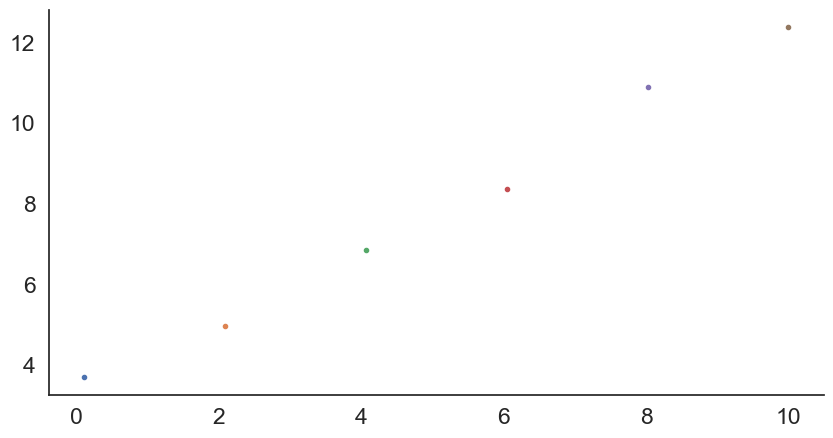

In [78]:
n = np.linspace(0.05, 10.0, 6)

for i in n:
    median_error = noises(i)
    plt.plot(i,median_error, '.')

plt.show()

We see a what seems to be linear increase of the median error with the noise, as we would have expected.

In [36]:
import pickle

file_name = 'linear_track_data.pickle' # change this name when you save new data

out_data = {}
out_data['x'] = x
out_data['t'] = t
out_data['spikes'] = spikes
out_data['track_length'] = track_length
out_data['fps'] = fps

with open('data/'+file_name,'wb') as f:
    pickle.dump(out_data,f)

## Exercise 2
---
In the loop implementation of the decoder, we used `poisson.logpmf(k,mu)` to calculate the log probability of observing $k$ spikes given an average firing rate of $\mu$. 
This is mathematically equivalent to `np.log(poisson.pmf(k,mu))`, in which we calculate the probability, and then take the log.


Re-run the decoding substituting this expression:

```
posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
```

To the line we are using to calculate the posterior.
Do you see any difference in the results? What do you think this is due to?




Answer:

I inserted this into the class notebook, because I didn't want to copy everything over here. If we change the last term in the new line pow(1,-15) to pow(10,-15), which is I think wanted, we don"t observe a difference. As stated in the exercise, the two expressions are the same, so that could be the reason.

If the line is inserted as shown here, we observe very different behaviour and the decoder performs very badly.

## Exercise 3
---
A - Estimate the quality of the sequence detection methods we saw in the lesson. How many false poistive does it find? How many false negatives?

B - Investigate the effect of `noise_x_react` and `noise_t_react` on the false positive rate and the false negative rate of our detection procedure.

C - What kind of sequence can our methods detect? What kind of activity, despide being sequential, could escape our detection method? Would you have an idea for a different method for sequence detection?


A: The methods we law in the lesson notebook were on the one hand to fit the activations of the cells in order to find the slope and derive from that if the activaiton was random or if there was a sequence playing and on the other hand the visual evaluation and with that comparing the true sequences with the decoded ones and estimating the median square error. In order to talk about false positives and false negatives, it makes more sense to think of the first method, where we simulated random sequences and some, where the animal actually moved. Here, the start and end point of the movement was randomly determined, thus there were some trajectories were the animal started in x=40cm and ended in x=44cm, this would give a slope of almost 0, eventhough there was very non-random movement. Interestingly, the distribution of the random slopes shows only positive values and also the distribution for the non-random sequences is shifted towards positive values. Since we look at random processes, I would say we have the tolerance to attribute a slope between -1<0<1 to a rdnom process. This would mean we have no false positives (by my definition). In the group with real requences there were around 8% of trails with a slope btween -1 and 1, which I would call a false negatives, because they seem random, but aren't.

B: Its shown below how I found the results discussed here. For both varying the noise in the timing of the spikes (t_noise) and the noise of the reactivation of the sequence (x_noise) I didn't observe a growing rate for false negatives, it stay around 8%. This is probably wrong ang goes against my intuiton, but I don't know where the error is.

C: Is already kind of answered. If the movement is only over a small part of the map, the slope becomes quite small and eventually falls into my definition of random. If the animal would also be able to run back and forth, the slopes could even out, leaving a slope close to zero. To compensate for that, we could cut the sequence into smaller pieces and determine the slopes for them. If they are all close to zero, the trail is random, if they show a distribution of values, it could be a movement pover the track. This would not fix the case where the animal doesn't move far over the map. There could be an extra check for this special case.

### Code for data generation

In [22]:
#### 3

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})

#download lesson data
download_data('https://surfdrive.surf.nl/files/index.php/s/TliAW2xObyy0keu')

#code: data import
data_file = 'data/linear_track_data.pickle'
with open(data_file, 'rb') as handle:
    data = pickle.load(handle)

x,t,spikes = data['x'],data['t'],data['spikes']
track_length = data['track_length']
fps = data['fps'] 
n_cells = len(spikes)

# we compute the poistion at which each spike was emitted
spike_positions = [np.interp(s, t, x) for s in spikes]
space_bins = np.arange(0., track_length, 5.) # binning in bins of 5 cms

# we compute histograms for each cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
spikes_hist = np.asarray(spikes_hist)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy 
# generate data 

spikes_count= [np.histogram(s,t)[0] for s in spikes]
spikes_count = np.asarray(spikes_count).T # we transpose the matrix to have the more familiar (samples x features) shape

def noise_check(x,t):
    n_events = 200 # number of reactivation events
    event_duration = 100 # in bins
    sampling_rate = 100 # sampling rate 
    t_react = np.arange(0,100)
    noise_x_react=x; # Noise in the reactivation of the sequence
    noise_t_react=t; # Noise in the timing of the spikes 
    noise_firing_rate = 0.1 # the baseline noise firing rate


    reactivation_events = np.zeros((n_events,event_duration))
    spikes_react = np.zeros((n_events,n_cells,event_duration))

    for event in range(n_events):
        if(event<=n_events//2):
        #Generate "real" sequences for the first half of events
            x_start = np.random.uniform(0,track_length) # Starting point
            x_end = np.random.uniform(0,track_length) # Ending point
            x_react = np.linspace(x_start,x_end,event_duration) \
                +np.random.normal(0,noise_x_react,size=event_duration)

        else:
            #Pick locations randomly for the second half 
            x_react = np.random.uniform(0,track_length,size=event_duration);

        x_react[x_react<0]=0;
        x_react[x_react>track_length]=track_length
        
        #store reactivation sequence
        reactivation_events[event,:] = x_react

        
        # Generate spikes according to the location being reactivated in this event
        
        for i in range(n_cells):
            binned_x = np.digitize(x_react,bins=np.linspace(0,track_length,firing_rate_maps.shape[-1]))-1
            inst_rate = firing_rate_maps[i,binned_x] + np.random.normal(0,noise_firing_rate,size=len(binned_x))
            inst_rate[inst_rate<0] = 0
            spikes_loc = np.where(np.random.poisson(inst_rate/sampling_rate)>0)
            spikes_loc = spikes_loc + np.round(np.random.normal(0,noise_t_react,size=len(spikes_loc)))
            spikes_loc = spikes_loc[np.logical_and(spikes_loc>0,spikes_loc<event_duration)]
            spikes_react[event,i,spikes_loc.astype(int)] = 1

    time_window = 5 # number of bins to aggregate during decoding

    reactivation_slope = np.zeros(n_events)

    for event in range(n_events):

        event_spikes = spikes_react[event]
        # First we bin the events in windows of 10 bins
        spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//time_window))
        # We generate a new spike matrix with the re-sized window
        for t_r in range(1,event_spikes.shape[1]//time_window):
            spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*time_window :(t_r)*time_window],axis=1)

    # to do: bayesian decoding
    t_resize = 10 # We use spikes from multiple time windows for the decoding

    reactivation_slopes = np.zeros(n_events)
    reactivation_pvalues = np.zeros(n_events)

    for event in range(n_events):

        event_spikes = spikes_react[event]
        spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//t_resize))

        # We generate a new spike matrix with the re-sized window
        for t_r in range(1,event_spikes.shape[1]//t_resize):
            spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*t_resize :(t_r)*t_resize],axis=1)


        # We then perform decoding on the aggregated spikes
        x_decoded = np.zeros(spikes_sampled.shape[1])

        for t_bin in range(spikes_sampled.shape[1]):

            if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes

                posterior = np.empty(firing_rate_maps.shape[-1])
                for i in range(len(posterior)):
                    posterior[i] = sum(poisson.logpmf(spikes_sampled[:,t_bin],firing_rate_maps[:,i]*t_resize/fps)+pow(1,-15))

                x_decoded[t_bin] = space_bins[np.argmax(posterior)]

            else:
                x_decoded[t_bin] = np.nan   

            # We fit a line to the decoded positions, and save the slope
            slope,_ = np.polyfit(np.arange(len(x_decoded)),x_decoded,deg=1)
            reactivation_slopes[event] = slope
            # And calculate the pvalue of the pearson correlation
            corr = pearsonr(np.arange(len(x_decoded)),x_decoded)
            reactivation_pvalues[event] = corr[1]


    false_positives = 0
    for i in range(len(reactivation_slopes)):
        if -1 < reactivation_slopes[i] < 1:
            false_positives = false_positives + 1

    return (false_positives/len(reactivation_slope))

In [30]:
#here the t noise is constant at 5, noise x is being varied
how_many = 10
for i in [0,1,5,10,15,20]:
    mean = 0
    for _ in range(how_many):
        mean = mean + noise_check(i,5)
    
    print("noise x = "+str(i)+ ", mean false positive rate = "+str(mean/how_many))

/var/folders/gw/1gkg7kb92xlb5cvtzpqrsmk40000gn/T/ipykernel_3849/1698811854.py:128: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = pearsonr(np.arange(len(x_decoded)),x_decoded)


noise x = 0, mean false positive rate = 0.089
noise x = 1, mean false positive rate = 0.07750000000000001
noise x = 5, mean false positive rate = 0.08249999999999999
noise x = 10, mean false positive rate = 0.07849999999999999
noise x = 15, mean false positive rate = 0.08399999999999999
noise x = 20, mean false positive rate = 0.089


In [31]:
#here the x noise is constant at 5, noise t is being varied
for i in [0,1,5,10,15,20]:
    mean = 0
    for _ in range(how_many):
        mean = mean + noise_check(5,i)
    
    print("noise x = "+str(i)+ ", mean false positive rate = "+str(mean/how_many))

/var/folders/gw/1gkg7kb92xlb5cvtzpqrsmk40000gn/T/ipykernel_3849/1698811854.py:128: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = pearsonr(np.arange(len(x_decoded)),x_decoded)


noise x = 0, mean false positive rate = 0.08399999999999999
noise x = 1, mean false positive rate = 0.09999999999999999
noise x = 5, mean false positive rate = 0.07799999999999999
noise x = 10, mean false positive rate = 0.07550000000000003
noise x = 15, mean false positive rate = 0.0845
noise x = 20, mean false positive rate = 0.08399999999999999
